In [1]:
# ---------- Imports ----------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.spatial as sp

plt.rcParams['figure.figsize'] = [17, 17]

In [2]:
# -------------------------------------
# ---------- Bounded Voronoi ----------
# -------------------------------------
# Code from: https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells

# ---------- Functions ----------
def in_box(towers, bounding_box):
    # Returns a new np.array of towers that within the bounding_box
    # bounding_box = [x_min, x_max, y_min, y_max]
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def bounded_voronoi(towers, bounding_box):
    # Generates a bounded vornoi diagram with finite regions
    # bounding_box = [x_min, x_max, y_min, y_max]

    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)

    # Mirror points left, right, above, and under to force finite regions
    points_center = towers[i, :]

    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])

    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])

    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])

    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])

    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)

    # Compute Voronoi
    vor = sp.Voronoi(points)

    # creates a new attibute for points that form the diagram within the region
    vor.filtered_points = points_center
    # grabs the first fifth of the regions, which are the original regions
    vor.filtered_regions = np.array(vor.regions, dtype=object)[vor.point_region[:vor.npoints//5]]
    
    return vor

# Finds the centroid of a region. First and last point should be the same.
def centroid_region(vertices):
    # Polygon's signed area
    A = 0
    # Centroid's x
    C_x = 0
    # Centroid's y
    C_y = 0
    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A = A + s
        C_x = C_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        C_y = C_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    A = 0.5 * A
    C_x = (1.0 / (6.0 * A)) * C_x
    C_y = (1.0 / (6.0 * A)) * C_y
    return np.array([[C_x, C_y]])


# Performs x iterations of loyd's algorithm to calculate a centroidal vornoi diagram
def generate_CVD(points, iterations, bounding_box):
    p = np.copy(points)

    for i in range(iterations):
        vor = bounded_voronoi(p, bounding_box)
        centroids = []

        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :] # grabs vertices for the region and adds a duplicate of the first one to the end
            centroid = centroid_region(vertices)
            centroids.append(list(centroid[0, :]))

        p = np.array(centroids)

    return bounded_voronoi(p, bounding_box)


def plot_vornoi_diagram(fig, vor, bounding_box, plotInitPts = False, plotRidgePts = True, plotRidge = True):
    # Plots voronoi data (vor) onto pyplot (fig)
    # bounding_box = [x_min, x_max, y_min, y_max]
    ax = fig.gca()

    # Plot initial points
    if plotInitPts:
        ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], '+r', label = 'Gauss Centres')
        
    for i, pnt in enumerate(vor.filtered_points):
        ax.annotate(str(i), (pnt))

    # Plot ridges points
    if plotRidgePts:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region, :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'go', label = 'Ridges Points' if first else '')
            first = False

    # Plot ridges
    if plotRidge:
        first = True
        for region in vor.filtered_regions:
            vertices = vor.vertices[region + [region[0]], :]
            ax.plot(vertices[:, 0], vertices[:, 1], 'k-', label = 'Ridges' if first else '')
            first = False

    # Tidy details 
    margin_percent = .1
    width = bounding_box[1]-bounding_box[0]
    height = bounding_box[3]-bounding_box[2]

    ax.set_xlim([bounding_box[0]-width*margin_percent, bounding_box[1]+width*margin_percent])
    ax.set_ylim([bounding_box[2]-height*margin_percent, bounding_box[3]+height*margin_percent])
    ax.legend()

    return fig

def plot_patch(fig, vor, colour, cellsIndices):
    ax = fig.gca()

    for cellsIndex in cellsIndices:
        region = vor.filtered_regions[cellsIndex]
        vertices = vor.vertices[region + [region[0]], :]
        ax.add_patch(Polygon(vertices, closed=True, facecolor=colour, alpha=0.5))
        
    return fig

In [3]:
# np.random.seed(1)
# n_towers = 100
# towers = np.random.rand(n_towers, 2)
# bounding_box = np.array([0., 1., 0., 1.]) # [x_min, x_max, y_min, y_max]

# for i in range(0, 9): 
#     vor = generate_CVD(towers, i, bounding_box)
#     fig = plt.figure()
#     fig = plot_vornoi_diagram(fig, vor, bounding_box, True)

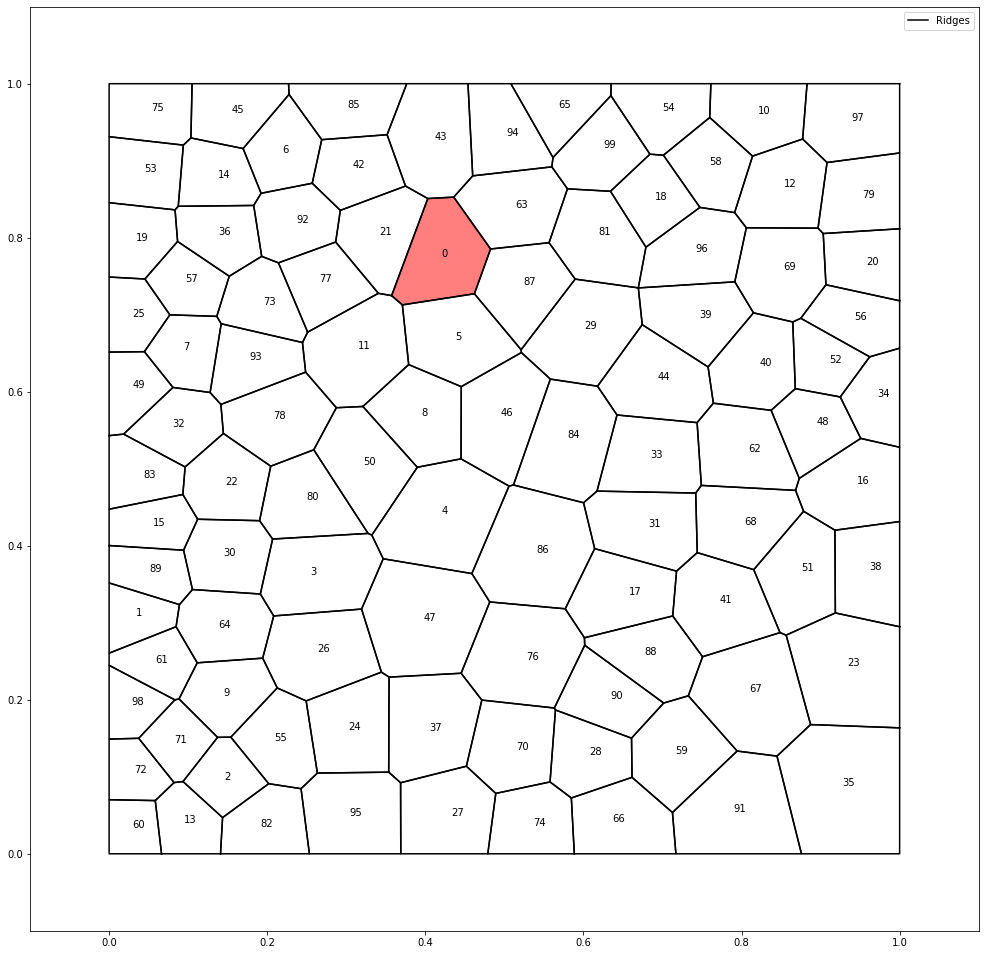

In [4]:
np.random.seed(1)
n_towers = 100
towers = np.random.rand(n_towers, 2)
bounding_box = np.array([0., 1., 0., 1.]) # [x_min, x_max, y_min, y_max]

vor = generate_CVD(towers, 3, bounding_box)
fig = plt.figure()
fig = plot_vornoi_diagram(fig, vor, bounding_box, False, False)
fig = plot_patch(fig, vor, 'red', [0])
# type(vor)

In [5]:
class problem:
    def __init__(self):
        self.regions = []
        self.direction = [1.0, 0.0]
        self.upstreamTracker = []
        
    def addData(self, vor, fig):
#         self.regions = [[] for region in vor.filtered_regions]
        self.regions = [{'neighbours':[],'upStreamNb':[],'downStreamNb':[]} for region in vor.filtered_regions]
        numRegs = len(vor.filtered_regions)
#         print(len(vor.filtered_regions))
        
        for i, ridge in enumerate(vor.ridge_points):
            regionA = ridge[0]
            regionB = ridge[1]
            if ((regionA < numRegs) and (regionA < numRegs)):
                ridgeVerts = vor.ridge_vertices[i]
                vertexA = vor.vertices[ridgeVerts[0]]
                vertexB = vor.vertices[ridgeVerts[1]]
                midPointA = 0.5*(vertexA + vertexB)
                dx = vertexB[0] - vertexA[0]
                dy = vertexB[1] - vertexA[1]
                normalA = [dy, -dx]
                
    
                regionACent = vor.points[regionA]
                regionBCent = vor.points[regionB]
                midPointB = 0.5*(regionACent + regionBCent)
                dx = regionBCent[0] - regionACent[0]
                dy = regionBCent[1] - regionACent[1]
                normalB = [dx, dy]
                print(regionA)
                print(regionB)
                print(midPointA)
                
                ax = fig.gca()
#                 ax.plot(vertexA[0], vertexA[1], '+b', label = 'vertexA')
#                 ax.plot(vertexB[0], vertexB[1], '+b', label = 'vertexB')
#                 ax.plot(regionACent[0], regionACent[1], '+g', label = 'regionACent')
#                 ax.plot(regionBCent[0], regionBCent[1], '+g', label = 'regionBCent')
#                 ax.plot(midPointA[0], midPointA[1], '+b', label = 'midPointA')
#                 ax.plot(midPointB[0], midPointB[1], '+g', label = 'midPointB')
                ax.plot([midPointA[0], midPointA[0] + 0.25*dx], [midPointA[1], midPointA[1] + 0.25*dy], 'r-', label = 'dir')
                ax.legend()
                
#                 break
        

In [ ]:
fig = plt.figure()
fig = plot_vornoi_diagram(fig, vor, bounding_box, True, False)

prob = problem()
prob.addData(vor, fig)

28
90
[0.6127406  0.16846215]
28
70
[0.56119338 0.140041  ]
28
59
[0.66117469 0.12471656]
28
66
[0.62310449 0.0858872 ]
28
74
[0.57124075 0.08290108]
18
96
[0.71320511 0.81352393]
18
81
[0.6566488  0.82399496]
18
99
[0.65917595 0.88436437]
18
58
[0.72428697 0.87322501]
18
54
[0.69268038 0.90778815]
58
96
[0.76929764 0.83599688]
58
10
[0.78687599 0.93102194]
58
12
[0.80261979 0.8693131 ]
58
54
[0.73050195 0.93160052]
80
3
[0.2671984  0.41236569]
80
50
[0.29322056 0.47031047]
80
78
[0.23164653 0.51394875]
80
22
[0.19738029 0.46792762]
80
30
[0.19858032 0.42063314]
26
47
[0.33188886 0.27683292]
26
24
[0.29682975 0.21719114]
26
3
[0.26377793 0.31332339]
26
55
[0.23096587 0.20694149]
26
9
[0.20348221 0.23469684]
26
64
[0.20123517 0.28143697]
3
64
[0.19974463 0.32310092]
3
30
[0.1990642  0.37302232]
3
4
[0.33953216 0.39843065]
3
47
[0.33305625 0.35042976]
3
50
[0.32994741 0.41490188]
30
22
[0.15117502 0.43348492]
30
15
[0.10311075 0.41431362]
30
64
[0.14835244 0.340239  ]
30
89
[0.09980429 0